## FC

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words("indonesian") + list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iwan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data FC

In [11]:
df = pd.read_csv("data/amalsholeh_review _FC.csv")
df.head()

content     FC
0  Tidak bisa "sedekah rahasia". 1. Setelah sedek...   True
1  Mohon maaf saya ubah ratingnya untuk perbaikan...  False
2  Amal Sholeh kenapa ya? Ini akun ku tiba tiba k...  False
3  Suka banget sama aplikasinya, topupnya mudah, ...  False
4  Aplikasinya mudah digunakan, dan banyak fitur ...   True

In [12]:
df.FC.value_counts()

False    360
True     110
Name: FC, dtype: int64

In [13]:
df.FC.value_counts(normalize=True)

False    0.765957
True     0.234043
Name: FC, dtype: float64

### Encoding

In [14]:
from gensim.models import FastText

In [15]:
w2v = FastText.load("model/fasttext/amalsholeh_review.fasttext").wv

In [16]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, w2v, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

In [17]:
vecs.shape

(470, 200)

### Dataset Splitting

In [18]:
X = vecs
y = df.FC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((376, 200), (94, 200), (376,), (94,))

### Training KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [20]:
pipeline = Pipeline([
    ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 885 out of 900 | elapsed:   22.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   22.7s finished


{'algo__n_neighbors': 29, 'algo__p': 2, 'algo__weights': 'uniform'}
0.8191489361702128 0.8162162162162161 0.851063829787234


### Evaluation KNN

In [21]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

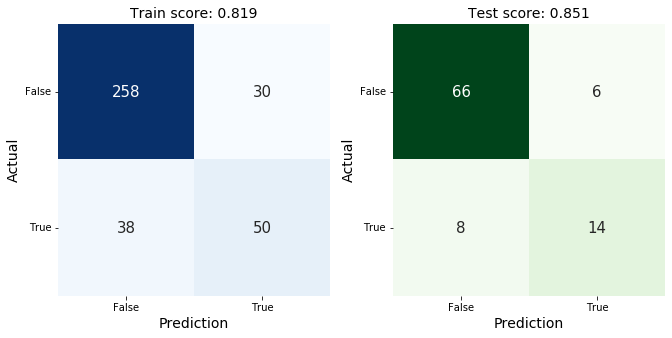

In [22]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [23]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

       False       0.87      0.90      0.88       288
        True       0.62      0.57      0.60        88

    accuracy                           0.82       376
   macro avg       0.75      0.73      0.74       376
weighted avg       0.81      0.82      0.82       376


Test report
              precision    recall  f1-score   support

       False       0.89      0.92      0.90        72
        True       0.70      0.64      0.67        22

    accuracy                           0.85        94
   macro avg       0.80      0.78      0.79        94
weighted avg       0.85      0.85      0.85        94



### Training SVM

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [25]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s


{'algo__C': 1.0, 'algo__gamma': 1.0}
0.8617021276595744 0.835135135135135 0.851063829787234


[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:    4.8s finished


### Evaluation SVM

In [26]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve

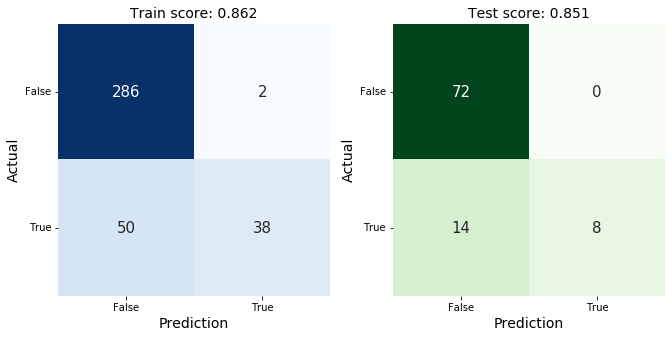

In [27]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [28]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

       False       0.85      0.99      0.92       288
        True       0.95      0.43      0.59        88

    accuracy                           0.86       376
   macro avg       0.90      0.71      0.76       376
weighted avg       0.87      0.86      0.84       376


Test report
              precision    recall  f1-score   support

       False       0.84      1.00      0.91        72
        True       1.00      0.36      0.53        22

    accuracy                           0.85        94
   macro avg       0.92      0.68      0.72        94
weighted avg       0.88      0.85      0.82        94



### FC sentiment

### Import Data Sentiment

In [29]:
df = pd.read_csv("data/amalsholeh_review _FC_sentiment.csv")
df.head()

content    FC  value sentiment
0  Tidak bisa "sedekah rahasia". 1. Setelah sedek...  True      2   negatif
1  Aplikasinya mudah digunakan, dan banyak fitur ...  True      1   positif
2  Alhamdulillah bisa sedekah subuh secara otomat...  True      2   negatif
3  MasyaAllah ini aplikasi paling terbagus menuru...  True      1   positif
4  Aplikasi sesuai keinginan saya, ada sedekah ha...  True      2   negatif

In [30]:
df.sentiment.value_counts()

positif    60
negatif    50
Name: sentiment, dtype: int64

In [31]:
df.sentiment.value_counts(normalize=True)

positif    0.545455
negatif    0.454545
Name: sentiment, dtype: float64

### Encoding

In [32]:
w2v = FastText.load("model/fasttext/amalsholeh_review.fasttext").wv

In [33]:
def norm_sent_vector(sentence, w2v_model, stopwords=None):
    sw_removed_sentence = [word for word in word_tokenize(sentence) 
                           if word not in stopwords]
    if len(sw_removed_sentence) == 0:
        return np.zeros(w2v_model.vector_size)
    vecs = [w2v_model[word] for word in sw_removed_sentence]    
    vecs = [vec / np.linalg.norm(vec) for vec in vecs 
            if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

vecs = [norm_sent_vector(sentence, w2v, sw_indo) 
        for sentence in df.content]
vecs = np.array(vecs)

### Dataset Splitting

In [34]:
X = vecs
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((88, 200), (22, 200), (88,), (22,))

### Training KNN

In [35]:
pipeline = Pipeline([
    ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


{'algo__n_neighbors': 5, 'algo__p': 1.5, 'algo__weights': 'uniform'}
0.8863636363636364 0.8833333333333332 0.7727272727272727


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    1.6s finished


### Evaluation KNN

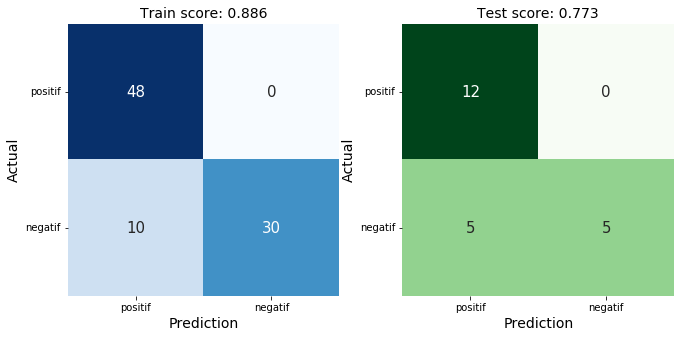

In [36]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [37]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

     negatif       1.00      0.75      0.86        40
     positif       0.83      1.00      0.91        48

    accuracy                           0.89        88
   macro avg       0.91      0.88      0.88        88
weighted avg       0.91      0.89      0.88        88


Test report
              precision    recall  f1-score   support

     negatif       1.00      0.50      0.67        10
     positif       0.71      1.00      0.83        12

    accuracy                           0.77        22
   macro avg       0.85      0.75      0.75        22
weighted avg       0.84      0.77      0.75        22



### Training SVM

In [38]:
pipeline = Pipeline([
    ('algo', SVC())
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=10, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s


{'algo__C': 1.0, 'algo__gamma': 10.0}
0.9886363636363636 0.898611111111111 0.8181818181818182


[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:    1.5s finished


### Evaluation SVM

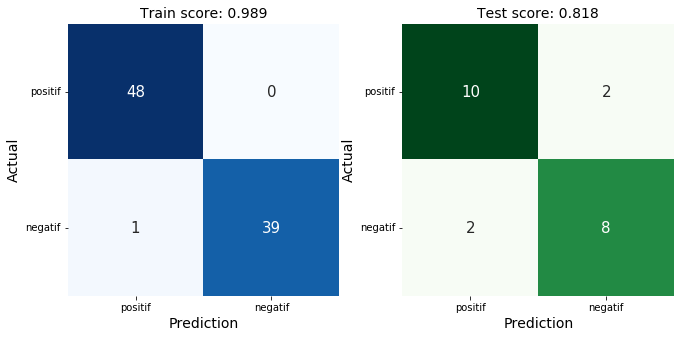

In [39]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [40]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

     negatif       1.00      0.97      0.99        40
     positif       0.98      1.00      0.99        48

    accuracy                           0.99        88
   macro avg       0.99      0.99      0.99        88
weighted avg       0.99      0.99      0.99        88


Test report
              precision    recall  f1-score   support

     negatif       0.80      0.80      0.80        10
     positif       0.83      0.83      0.83        12

    accuracy                           0.82        22
   macro avg       0.82      0.82      0.82        22
weighted avg       0.82      0.82      0.82        22

